# Regional Distribution of Diseases in UK Biobank
Merge assessment centre data with disease data and explore distributions by region (England, Scotland, Wales).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

data_dir = "/orcd/pool/003/dbertsim_shared/ukb/"
data_dir_local = "../data/"

## 1. Load helper data and define utilities

In [5]:
field = pd.read_csv(f"{data_dir_local}field.tsv", sep="\t")
field_dict = dict(zip(field["field_id"], field["title"]))

def rename_columns(df, field_dict):
    for c in set(df.columns) - {"eid"}:
        df = df.rename(columns={c: c.split("p")[1].split("_")[0]})
    for c in set(df.columns) - {"eid"}:
        df = df.rename(columns={c: field_dict[int(c)]})
    return df

## 2. Load assessment centre data and map to region

In [7]:
df_assessment_centre = rename_columns(
    pd.read_csv(f"{data_dir_local}assessment_centre.csv"), field_dict
)

ASSESSMENT_CENTRE_TO_COUNTRY = {
    "Barts": "England",
    "Birmingham": "England",
    "Bristol": "England",
    "Bury": "England",
    "Cheadle (revisit)": "England",
    "Croydon": "England",
    "Hounslow": "England",
    "Leeds": "England",
    "Liverpool": "England",
    "Manchester": "England",
    "Middlesborough": "England",
    "Newcastle": "England",
    "Nottingham": "England",
    "Oxford": "England",
    "Reading": "England",
    "Sheffield": "England",
    "Stockport (pilot)": "England",
    "Stoke": "England",
    "Cheadle (imaging)": "England",
    "Reading (imaging)": "England",
    "Newcastle (imaging)": "England",
    "Bristol (imaging)": "England",
    "Edinburgh": "Scotland",
    "Glasgow": "Scotland",
    "Cardiff": "Wales",
    "Swansea": "Wales",
    "Wrexham": "Wales",
}

df_assessment_centre["region"] = (
    df_assessment_centre["UK Biobank assessment centre"]
    .map(ASSESSMENT_CENTRE_TO_COUNTRY)
)

print(f"Assessment centre shape: {df_assessment_centre.shape}")
df_assessment_centre.head()

Assessment centre shape: (501931, 3)


,eid,UK Biobank assessment centre,region
0,4284267,Manchester,England
1,2846553,Bristol,England
2,5667800,Cardiff,Wales
3,3124022,Middlesborough,England
4,1986445,Sheffield,England


## 3. Load disease data and preprocess

In [9]:
df_disease = pd.read_csv(f"{data_dir}blood_protein_diseases_clean.csv")
print(f"Disease data shape: {df_disease.shape}")
df_disease.head()

Disease data shape: (52995, 3036)


,eid,Age at recruitment,Sex_male,Ethnic background,Body mass index (BMI),"Systolic blood pressure, automated reading","Diastolic blood pressure, automated reading",Townsend deprivation index at recruitment,Smoking status,Alcohol intake frequency.,...,hypertensive_heart_kidney_diseases_time_to_diagnosis,ischemic_heart_disease_time_to_diagnosis,liver_disease_time_to_diagnosis,lower_respiratory_disease_time_to_diagnosis,other_dementia_time_to_diagnosis,parkinsons_time_to_diagnosis,peripheral_vascular_disease_time_to_diagnosis,stroke_time_to_diagnosis,type_1_diabetes_time_to_diagnosis,type_2_diabetes_time_to_diagnosis
0,1000083,49,0,British,24.7295,116.0,71.0,-3.96,Previous,Three or four times a week,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000380,62,0,British,31.2026,124.0,81.0,-5.00,Never,Daily or almost daily,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001803,47,0,Any other white background,24.2187,98.0,57.0,2.00,Never,Never,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1002917,52,1,British,20.1477,132.0,67.0,-4.23,Current,Special occasions only,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003287,69,0,British,28.1479,166.0,61.0,6.38,Previous,Three or four times a week,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
olink_cols = [col for col in df_disease.columns if col.startswith("olink")]
threshold = 0.6

# Compute the fraction of missing olink values per row
row_missing_fraction = df_disease[olink_cols].isna().mean(axis=1)

# Filter out rows with >30% missing olink values
rows_to_drop = df_disease[row_missing_fraction >= threshold].index

df_disease = df_disease[row_missing_fraction < threshold]

# Compute the fraction of missing values for these columns
missing_fraction = df_disease[olink_cols].isna().mean()

# Drop the columns with >threshold missing
cols_to_drop = missing_fraction[missing_fraction >= threshold].index # only 3 columns
df_disease = df_disease.drop(columns=[col for col in olink_cols if col in cols_to_drop])

print(f"dropping patients: {len(rows_to_drop)}")
print(f"dropping cols: {len(cols_to_drop)}")

dropping patients: 398
dropping cols: 3


In [11]:
df = pd.merge(
    df_disease,
    df_assessment_centre[["eid", "UK Biobank assessment centre", "region"]],
    how="left",
    on="eid",
)
print(f"Merged shape: {df.shape}")
print(f"Region coverage: {df['region'].notna().mean():.2%}")
df.head()

Merged shape: (52597, 3035)
Region coverage: 100.00%


,eid,Age at recruitment,Sex_male,Ethnic background,Body mass index (BMI),"Systolic blood pressure, automated reading","Diastolic blood pressure, automated reading",Townsend deprivation index at recruitment,Smoking status,Alcohol intake frequency.,...,liver_disease_time_to_diagnosis,lower_respiratory_disease_time_to_diagnosis,other_dementia_time_to_diagnosis,parkinsons_time_to_diagnosis,peripheral_vascular_disease_time_to_diagnosis,stroke_time_to_diagnosis,type_1_diabetes_time_to_diagnosis,type_2_diabetes_time_to_diagnosis,UK Biobank assessment centre,region
0,1000083,49,0,British,24.7295,116.0,71.0,-3.96,Previous,Three or four times a week,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Newcastle,England
1,1000380,62,0,British,31.2026,124.0,81.0,-5.00,Never,Daily or almost daily,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leeds,England
2,1001803,47,0,Any other white background,24.2187,98.0,57.0,2.00,Never,Never,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Barts,England
3,1002917,52,1,British,20.1477,132.0,67.0,-4.23,Current,Special occasions only,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bury,England
4,1003287,69,0,British,28.1479,166.0,61.0,6.38,Previous,Three or four times a week,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middlesborough,England


## 4. Distribution by region (England, Scotland, Wales)

Overall region distribution:


,count,pct
England,46742,88.87
Scotland,3699,7.03
Wales,2154,4.10


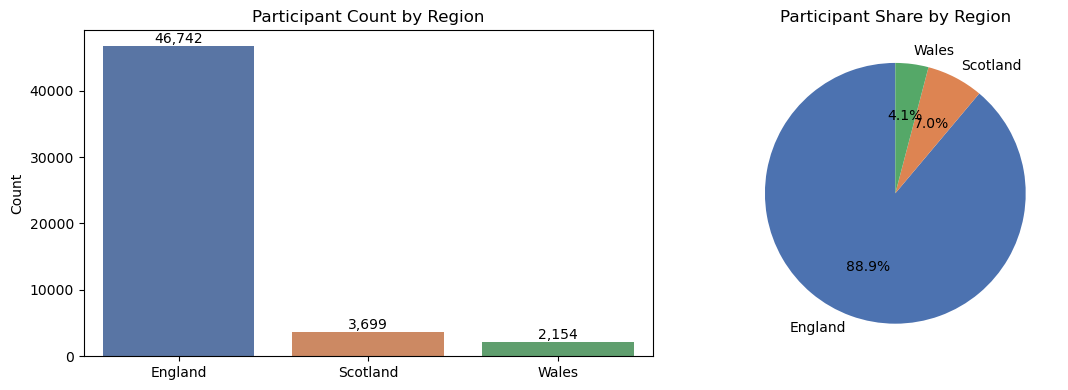

In [12]:
region_counts = df["region"].value_counts().sort_index()
region_pct = df["region"].value_counts(normalize=True).sort_index() * 100

region_summary = pd.DataFrame({"count": region_counts, "pct": region_pct.round(2)})
print("Overall region distribution:")
display(region_summary)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

palette = {"England": "#4C72B0", "Scotland": "#DD8452", "Wales": "#55A868"}
order = ["England", "Scotland", "Wales"]

sns.barplot(x=region_counts.index, y=region_counts.values, order=order,
            palette=palette, ax=axes[0])
axes[0].set_title("Participant Count by Region")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("")
for i, (idx, val) in enumerate(zip(order, [region_counts.get(r, 0) for r in order])):
    axes[0].text(i, val, f"{val:,}", ha="center", va="bottom", fontsize=10)

axes[1].pie(
    [region_counts.get(r, 0) for r in order],
    labels=order,
    colors=[palette[r] for r in order],
    autopct="%1.1f%%",
    startangle=90,
)
axes[1].set_title("Participant Share by Region")

plt.tight_layout()
plt.show()

## 5. Disease distribution within each region

In [24]:
time_cols = [c for c in df.columns if c.endswith('_time_to_diagnosis')]
disease_cols = [c.replace('_time_to_diagnosis', '') for c in time_cols]

for disease in disease_cols:
    df[f"{disease}_future"] = ((df[f"{disease}_time_to_diagnosis"] >= 0) & (df[f"{disease}_time_to_diagnosis"] <= 5)).astype(int)

In [17]:
region_disease_counts = (
    df.groupby("region")[disease_cols]
    .sum()
    .T
    .reindex(columns=order)
)
region_disease_counts["total"] = region_disease_counts.sum(axis=1)
region_disease_counts = region_disease_counts.sort_values("total", ascending=False)

print("Disease case counts by region:")
display(region_disease_counts)

Disease case counts by region:


region,England,Scotland,Wales,total
depression,4192,325,199,4716
ischemic_heart_disease,2857,269,138,3264
anxiety_disorders,2055,87,66,2208
type_2_diabetes,1379,135,108,1622
lower_respiratory_disease,1084,71,87,1242
copd,1068,101,50,1219
atrial_fibrillation,1018,95,50,1163
stroke,933,83,49,1065
peripheral_vascular_disease,879,57,44,980
chronic_kidney_disease,853,16,13,882


In [18]:
region_totals = df["region"].value_counts().reindex(order)
region_disease_prevalence = (
    df.groupby("region")[disease_cols]
    .mean()
    .T
    .reindex(columns=order)
    * 100
)
region_disease_prevalence = region_disease_prevalence.round(2)

print("Disease prevalence (%) by region:")
display(region_disease_prevalence)

Disease prevalence (%) by region:


region,England,Scotland,Wales
acute_kidney_injury,0.23,0.43,0.09
alzheimers_disease,0.01,0.05,0.00
anxiety_disorders,4.40,2.35,3.06
atrial_fibrillation,2.18,2.57,2.32
chronic_kidney_disease,1.82,0.43,0.60
copd,2.28,2.73,2.32
depression,8.97,8.79,9.24
end_stage_renal_disease,0.52,0.84,0.56
heart_failure,0.92,1.05,0.93
hypertensive_heart_kidney_diseases,0.36,0.16,0.37


In [25]:
disease_cols_future = [f"{d}_future" for d in disease_cols]

region_totals = df["region"].value_counts().reindex(order)
region_disease_prevalence = (
    df.groupby("region")[disease_cols_future]
    .mean()
    .T
    .reindex(columns=order)
    * 100
)
region_disease_prevalence = region_disease_prevalence.round(2)

print("Disease prevalence (%) by region:")
display(region_disease_prevalence)

Disease prevalence (%) by region:


region,England,Scotland,Wales
acute_kidney_injury_future,0.97,0.59,0.32
alzheimers_disease_future,0.18,0.30,0.28
anxiety_disorders_future,1.68,0.24,0.74
atrial_fibrillation_future,2.06,1.81,1.72
chronic_kidney_disease_future,1.87,0.54,0.32
copd_future,1.24,1.03,1.30
depression_future,1.45,2.03,2.09
end_stage_renal_disease_future,0.22,0.24,0.23
heart_failure_future,0.93,1.14,1.67
hypertensive_heart_kidney_diseases_future,0.55,0.14,0.56


In [27]:
df = df.drop(columns = disease_cols_future)
df = df.drop(columns = ["anxiety_disorders", "depression", "anxiety_disorders_time_to_diagnosis", "depression_time_to_diagnosis"])

In [28]:
df.head()

,eid,Age at recruitment,Sex_male,Ethnic background,Body mass index (BMI),"Systolic blood pressure, automated reading","Diastolic blood pressure, automated reading",Townsend deprivation index at recruitment,Smoking status,Alcohol intake frequency.,...,liver_disease_time_to_diagnosis,lower_respiratory_disease_time_to_diagnosis,other_dementia_time_to_diagnosis,parkinsons_time_to_diagnosis,peripheral_vascular_disease_time_to_diagnosis,stroke_time_to_diagnosis,type_1_diabetes_time_to_diagnosis,type_2_diabetes_time_to_diagnosis,UK Biobank assessment centre,region
0,1000083,49,0,British,24.7295,116.0,71.0,-3.96,Previous,Three or four times a week,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Newcastle,England
1,1000380,62,0,British,31.2026,124.0,81.0,-5.00,Never,Daily or almost daily,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leeds,England
2,1001803,47,0,Any other white background,24.2187,98.0,57.0,2.00,Never,Never,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Barts,England
3,1002917,52,1,British,20.1477,132.0,67.0,-4.23,Current,Special occasions only,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bury,England
4,1003287,69,0,British,28.1479,166.0,61.0,6.38,Previous,Three or four times a week,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middlesborough,England


## 6. Train/Val/Test/External Dataset Split

In [29]:
df_england = df.loc[df['region'] == 'England']
df_ext = df.loc[df['region'] != 'England']

df_ext.to_csv(f"{data_dir}ukb_disease_scotland_wales.csv",index=False)
df_england.to_csv(f"{data_dir}ukb_disease_england.csv",index=False)

In [30]:
def bin_ttd(x):
    if pd.isna(x):         return "NA"
    if x <= 30/365.25:     return "<0"
    if 30/365.25 < x <= 1: return "0-1"   # (0,1]
    return ">1"

def proportions(frame, label):
    return (frame[f"{label}_strata"].value_counts(normalize=False)
            .reindex(["<0","0-1",">1","NA"])
            .fillna(0))

In [37]:
disease_cols.remove("anxiety_disorders")
disease_cols.remove("depression")
for disease in disease_cols:
    df_england[f"{disease}_strata"] = df_england[f"{disease}_time_to_diagnosis"].apply(bin_ttd)

In [38]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def prevalence(table, cols):
    return pd.DataFrame({
        "prevalence": [table[c].mean() for c in cols],
        "n": [table[c].sum() for c in cols]
    }, index=cols)

def multilabel_stratified_split(
    df: pd.DataFrame,
    test_size=0.4,
    random_state=42,
    time=0
):
    """
    Splits df into train/test so that each label in label_cols
    has (approximately) the same prevalence in both splits,
    accounting for multi-label rows.
    """
    # 1) Build the multi-label target matrix (n_samples x n_labels)
    # Y = df[label_cols].astype(int).to_numpy()
    df_copy = df.copy()
    Y_cols = []
    for label in disease_cols:
        for strata in ["<0","0-1",">1"]:
            df_copy[f"{label}_time_to_diagnosis_{strata}"] = (df[f"{label}_strata"] == strata)
            Y_cols.append(f"{label}_time_to_diagnosis_{strata}")
    Y = df_copy[Y_cols].to_numpy()

    # 2) Set up the multi-label stratified splitter
    msss = MultilabelStratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )

    # 3) Run the split; indices refer to rows of df
    (train_idx, test_idx), = msss.split(df, Y)
    
    train_df = df.iloc[train_idx].copy()
    test_df  = df.iloc[test_idx].copy()

    train_df_copy = df_copy.iloc[train_idx].copy()
    test_df_copy  = df_copy.iloc[test_idx].copy()
    
    summary = pd.concat(
        {
            "train": prevalence(train_df_copy, Y_cols),
            "test": prevalence(test_df_copy, Y_cols),
        },
        axis=1,
    )
    print(summary)

    return train_df, test_df

# Make the split
train_df, validtest_df = multilabel_stratified_split(df_england, test_size=0.6)
valid_df, test_df = multilabel_stratified_split(validtest_df, test_size=0.5)

                                                        train        \
                                                   prevalence     n   
acute_kidney_injury_time_to_diagnosis_<0             0.002300    43   
acute_kidney_injury_time_to_diagnosis_0-1            0.000856    16   
acute_kidney_injury_time_to_diagnosis_>1             0.061778  1155   
alzheimers_disease_time_to_diagnosis_<0              0.000160     3   
alzheimers_disease_time_to_diagnosis_0-1             0.000107     2   
alzheimers_disease_time_to_diagnosis_>1              0.014228   266   
atrial_fibrillation_time_to_diagnosis_<0             0.021769   407   
atrial_fibrillation_time_to_diagnosis_0-1            0.002888    54   
atrial_fibrillation_time_to_diagnosis_>1             0.070817  1324   
chronic_kidney_disease_time_to_diagnosis_<0          0.018239   341   
chronic_kidney_disease_time_to_diagnosis_0-1         0.002621    49   
chronic_kidney_disease_time_to_diagnosis_>1          0.061190  1144   
copd_t

In [40]:
train_df = train_df.drop(columns = [f"{c}_strata" for c in disease_cols])
valid_df = valid_df.drop(columns = [f"{c}_strata" for c in disease_cols])
test_df = test_df.drop(columns = [f"{c}_strata" for c in disease_cols])


In [43]:
train_df.to_csv(f"{data_dir}ukb_disease_train.csv", index=False)
valid_df.to_csv(f"{data_dir}ukb_disease_valid.csv", index=False)
test_df.to_csv(f"{data_dir}ukb_disease_test.csv", index=False)